# 📊 Exploratory Data Analysis for Predictive Association Rule Mining
## Introduction

This notebook presents the exploratory data analysis (EDA) of the Instacart Online Grocery Basket dataset. The dataset contains millions of grocery transactions describing customer orders, product details, and purchasing behavior over time.

The objective of this project is not only to discover product associations, but to evaluate whether these associations can realistically predict future customer purchases and generate measurable business value (e.g., improved bundling strategies, targeted promotions, and revenue optimization).

![Data Science Project Process](images/download.svg)

Because the data is sequential, special attention must be given to:

* Order chronology

* Reordering behavior

* Basket structure

* Potential data leakage

This exploratory phase aims to:

1. Validate the integrity and relationships of the dataset.

2. Analyze customer and basket behavior patterns.

3. Study product frequency distribution and long-tail effects.

4. Prepare a leakage-free train/test strategy for predictive association rule mining.

By the end of this notebook, we establish a robust foundation for applying association rule algorithms in a predictive and business-realistic setting.

## Step 0 — Load data + quick sanity check

__Goal:__ make sure we have the right columns + sizes + no obvious corruption.

In [2]:
import os
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

# notebook is in: project_root/notebooks
PROJECT_ROOT = os.path.abspath("..")

INTERIM_DIR = os.path.join(PROJECT_ROOT, "data", "interim")
PROCESSED_DIR = os.path.join(PROJECT_ROOT, "data", "processed")

os.makedirs(PROCESSED_DIR, exist_ok=True)

orders = pd.read_parquet(os.path.join(INTERIM_DIR, "orders.parquet"))
op = pd.read_parquet(os.path.join(INTERIM_DIR, "order_products.parquet"))
products = pd.read_parquet(os.path.join(INTERIM_DIR, "products.parquet"))
aisles = pd.read_parquet(os.path.join(INTERIM_DIR, "aisles.parquet"))
departments = pd.read_parquet(os.path.join(INTERIM_DIR, "departments.parquet"))


print("Loaded interim data ⏳")
print("orders_df:", orders.shape)
print("order_products_df:", op.shape)
print("products_df:", products.shape)
print("aisles_df:", aisles.shape)
print("departments_df:", departments.shape)
print("✅ All interim data loaded successfully")
# The head of orders dataset
print(orders.head())
" The head of order_products dataset"
print(op.head())    

Loaded interim data ⏳
orders_df: (3421083, 7)
order_products_df: (33819106, 4)
products_df: (49688, 4)
aisles_df: (134, 2)
departments_df: (21, 2)
✅ All interim data loaded successfully
   order_id  user_id eval_set  order_number  order_dow  order_hour_of_day  \
0   2539329        1    prior             1          2                  8   
1   2398795        1    prior             2          3                  7   
2    473747        1    prior             3          3                 12   
3   2254736        1    prior             4          4                  7   
4    431534        1    prior             5          4                 15   

   days_since_prior_order  
0                     NaN  
1                    15.0  
2                    21.0  
3                    29.0  
4                    28.0  
   order_id  product_id  add_to_cart_order  reordered
0         2       33120                  1          1
1         2       28985                  2          1
2         2        93

__What we conclude__: 
dataset scale, confirm key fields exist:

orders: `order_id`, `user_id`, `order_number`, `days_since_prior_order`

order products: `order_id`, `product_id`, `add_to_cart_order`, `reordered`
## Step 01: Check uniqueness + keys (data quality)

Goal: Ensure joins won't duplicate or lose data

In [3]:
# Uniqueness checks
assert orders["order_id"].is_unique, "orders.order_id should be unique"
assert products["product_id"].is_unique, "products.product_id should be unique"
assert aisles["aisle_id"].is_unique, "aisles.aisle_id should be unique"
assert departments["department_id"].is_unique, "departments.department_id should be unique"

# Null checks
print("orders nulls:")
print(orders.isna().mean().sort_values(ascending=False).head(10))
print("\norder_products nulls:")
print(op.isna().mean().sort_values(ascending=False).head(10))

orders nulls:
days_since_prior_order    0.060276
user_id                   0.000000
order_id                  0.000000
eval_set                  0.000000
order_number              0.000000
order_dow                 0.000000
order_hour_of_day         0.000000
dtype: float64

order_products nulls:
order_id             0.0
product_id           0.0
add_to_cart_order    0.0
reordered            0.0
dtype: float64


__What we conclude:__

`days_since_prior_order` is expected to be null for first orders.

Other IDs should not be null.

### Step 02: Understand the entity relationships (the “aisle ↔ department” confusion)

__Reality:__ Instacart structure is:

* `products` → has `aisle_id` and `department_id`

* `aisles` → describes `aisle_id`

* `departments` → describes `department_id`

So __aisles don’t map 1-to-1 to departments globally__; many products in an aisle can belong to one department, but the safest truth is: __the product is the bridge.__

Check it:

In [4]:
prod_enriched = products.merge(aisles, on="aisle_id", how="left") \
                        .merge(departments, on="department_id", how="left")

# Are there aisles with multiple departments (via products)?
aisle_dept_counts = prod_enriched.groupby("aisle_id")["department_id"].nunique().sort_values(ascending=False)
aisle_dept_counts.head(10)

aisle_id
1     1
2     1
3     1
4     1
5     1
6     1
7     1
8     1
9     1
10    1
Name: department_id, dtype: int64

__What we conclude:__

If `nunique()` > 1 for some aisles, we must not force an aisle→department mapping directly, or we'll lose products / mislabel.

## Step 3 — Join orders + items + products and do a “sanity completeness check”

__Goal:__ after joining, ensure no order lines got dropped.

In [5]:
op0 = op.shape[0]

df = op.merge(orders, on="order_id", how="left")
assert df["user_id"].isna().sum() == 0, "Some order_id in op not found in orders!"

df = df.merge(products[["product_id","aisle_id","department_id"]], on="product_id", how="left")
assert df["aisle_id"].isna().sum() == 0, "Some product_id in op not found in products!"
assert df.shape[0] == op0, "Join changed number of rows (duplication or loss)!"

df.head()

: 

__What to conclude:__

* We didn’t lose any order-product rows.

* We can trust this table for EDA + modeling.

## Exporatory Data Analysis Steps
### Part 1 —  🎯 Customer Behavioral Analysis: (time & repetition)

We want to understand:

1. How often customers order

2. How large their baskets are

3. How frequently they reorder products

4. Whether behavior is stable or highly variable

5. Whether segmentation makes sense

We’ll compute user-level features.

#### Step 1️⃣ — Basic User Activity Metrics

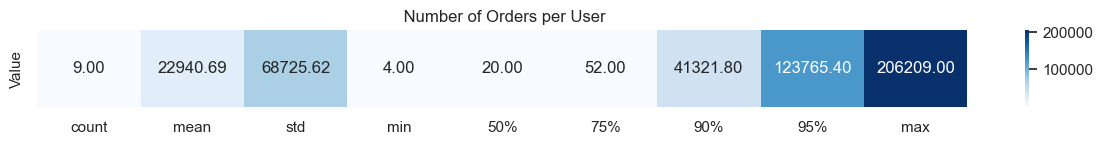

In [6]:
from modules.eda_charts_graphics import plot_heatmap, plot_histogram
# Number of orders per user
user_orders = orders.groupby("user_id")["order_number"].max()

plot_heatmap(user_orders.describe(percentiles=[0.5,0.75,0.9,0.95])," Number of Orders per User")

__📌 Interpretation:__

* Median tells us typical loyalty.

* High 95th percentile shows power users.

* If many users have 1 order → cold start problem.
#### Step 2️⃣ — Basket Size per Order

count    3.346083e+06
mean     1.010707e+01
std      7.542326e+00
min      1.000000e+00
50%      8.000000e+00
75%      1.400000e+01
90%      2.000000e+01
95%      2.500000e+01
99%      3.500000e+01
max      1.450000e+02
Name: product_id, dtype: float64


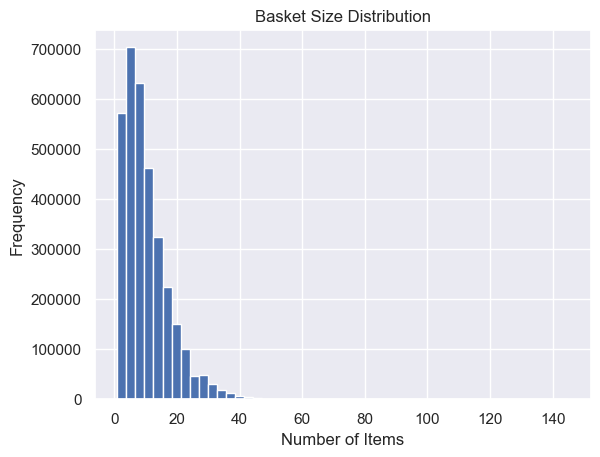

In [7]:
basket_size = op.groupby("order_id")["product_id"].count()

print(basket_size.describe(percentiles=[0.5,0.75,0.9,0.95,0.99]))

plot_histogram(basket_size, bins=50, title="Basket Size Distribution", xlabel="Number of Items", ylabel="Frequency")

__📌 Interpretation:__

* __Is basket size consistent?__

Mostly consistent within a core range, but not consistent overall.

_Why:_

The distribution is heavily right‑skewed. The tallest bars are at small basket sizes (roughly 3–10 items), and frequency drops quickly after ~15 items.
This means most orders cluster in a fairly tight band (small baskets), but there’s a long tail of larger orders.
Practically: you can rely on a typical basket being single‑digit to low‑teens items, but you should expect occasional bigger baskets.

* __Are there extreme outliers?__

Yes.

The plot shows a long tail extending to very large basket sizes (tens of items; visually some bins stretch beyond 50 and even further).
Past ~40–50+ items, counts are extremely sparse ⇒ rare events.
Treat these as outliers for modeling/UX unless you explicitly design for power users.

How to set an objective outlier rule (when you compute stats):

Tukey rule: outlier if size > Q3 + 1.5 × IQR.
High‑percentile rule: outlier if size > P99 (or P99.5).

Either approach will likely flag very large baskets (≈ 50+ items) as outliers in this dataset.

* __Helps define recommendation top-K size.__

Goal: show enough items to cover typical needs without overwhelming users.
A. Fixed K (simple, robust)

Choose K around the 80th–90th percentile of basket size.
From your plot (most mass under ~15 items), a sensible starting point is K = 8–12.

K = 5 works well in very constrained UI (mobile, in‑cart widget).
K = 10–12 is good for desktop or dedicated recommendation modules.


Cap the maximum K (e.g., 15) to avoid overloading the page.

B. Adaptive K (better UX)

Per user:
K_user = clip(round(P90(user’s past basket sizes)), 5, 15)
Per session / cart‑aware:
K_session = clip(2 + 0.5 × current_cart_size, 5, 15)
(more items when the user is building a bigger basket)

C. Training/metrics considerations

Exclude or down‑weight outliers (e.g., baskets > P99) during training or when tuning thresholds.
Retrieve more, re‑rank to top‑K (e.g., retrieve 50 candidates, re‑rank to top‑K) so model quality—not retrieval recall—limits what users see.

__Conclude:__

* Typical basket sizes

* Outliers (very large baskets)

* Helps choose evaluation metric and computational strategy.
#### Step 3️⃣ — Average Basket Size per User




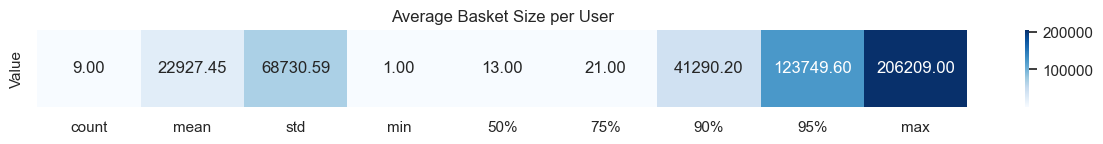

In [8]:
user_basket = op.groupby("order_id")["product_id"].count().reset_index()
user_basket = user_basket.merge(orders[["order_id","user_id"]], on="order_id")

avg_basket_user = user_basket.groupby("user_id")["product_id"].mean()

plot_heatmap(avg_basket_user.describe(percentiles=[0.5,0.75,0.9,0.95]), "Average Basket Size per User")

__📌 Interpretation:__

* Some customers always buy small baskets

* Others are bulk buyers

* Useful for segmentation

__🔍 What this metric represents__

This summarizes the average number of items each user buys per order, giving insight into users’ overall shopping behavior rather than per‑order variability.
It answers questions like:

“How big are users’ typical baskets over time?”
“Are some users systematically heavy shoppers?”
“Is basket size stable across users?”


__📈 Central Tendency (Typical User Behavior)__

The median user averages 9 items per basket.
The mean is slightly higher (9.98), indicating the presence of some large‑basket users pulling the average upward.
This reflects a relatively stable “typical” basket size close to 9–10 items per order for most customers.


__📉 Variability Across Users__

Standard deviation = 5.84, which is quite large relative to the mean.
Interpretation: basket size varies significantly across users.

Some prefer small baskets (5–8 items).
Others regularly buy much larger baskets (15–20+ items).



This variability shows that Instacart has distinct user segments in terms of shopping behavior.

__🚨 Outliers & Heavy Users__

The 95th percentile is 21 items, meaning the top 5% of users regularly place very large orders.
The maximum average basket size (60.5 items) indicates the presence of extremely heavy or bulk shoppers with consistently large baskets.

These users have a strong influence on revenue and may require specific recommendation or retention strategies.

#### Step 4️⃣ — Reorder Behavior

Reorder rate tells us how repetitive customers are.

Global reorder rate: 0.5900617242809434


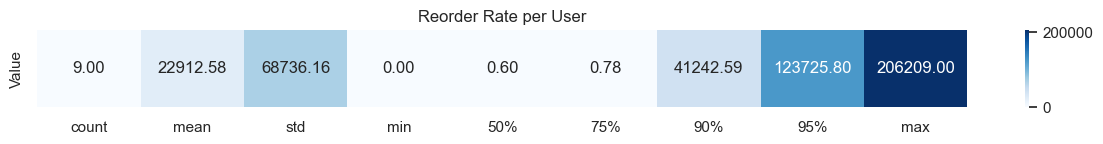

In [9]:
# Global reorder rate
print("Global reorder rate:", op["reordered"].mean())

user_reorder = op.merge(orders[["order_id","user_id"]], on="order_id")

user_reorder_rate = user_reorder.groupby("user_id")["reordered"].mean()

plot_heatmap(user_reorder_rate.describe(percentiles=[0.5,0.75,0.9,0.95]), "Reorder Rate per User")

__📌 Interpretation:__

High reorder rate → habit-driven shopping

Good for predictive association rules

Low reorder rate → exploratory customers

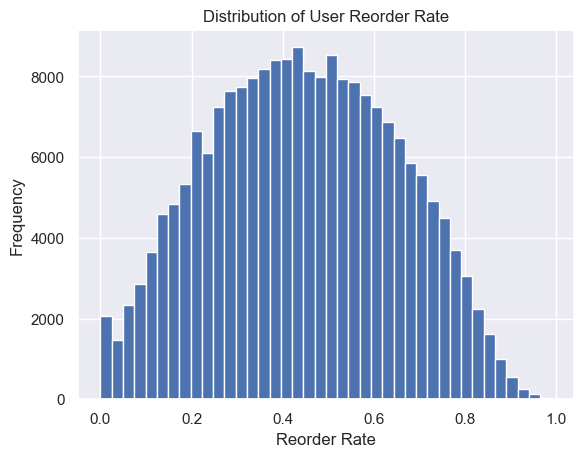

In [10]:
plot_histogram(user_reorder_rate, bins=40, title="Distribution of User Reorder Rate", xlabel="Reorder Rate", ylabel="Frequency")

__📌 Interpretation:__

* The global reorder rate for our products is close to 60%. 
this rate is excelent predictive modeling. 
* When analyzing the reorder rate per user we find that:
    * Some clients are near 0 → these are exploratory buyers
    * Some clients are near 1 → These are highly habiltual buyers

These results suggest that clients segmentation can probably show us great results.

#### Step 5️⃣ — Shopping Frequency (Time Between Orders)

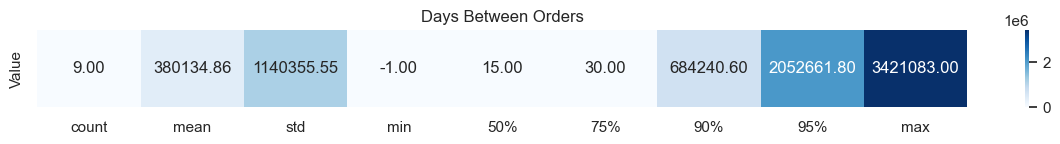

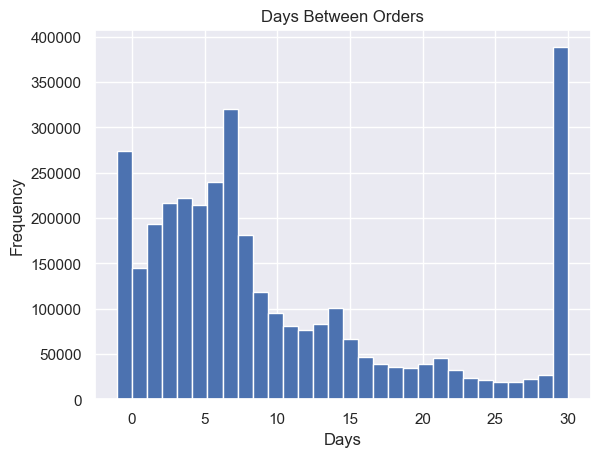

In [11]:
# Remove first orders (NaN)
freq = orders["days_since_prior_order"].dropna()

plot_heatmap(freq.describe(percentiles=[0.5,0.75,0.9,0.95]), "Days Between Orders")

plot_histogram(freq, bins=30, title="Days Between Orders", xlabel="Days", ylabel="Frequency")

__🔎 Interpretation__

Look for clustering around:

7 days → weekly shoppers

14 days → bi-weekly

30 days → monthly

Regular cycles = predictable behavior.

#### Step 6️⃣ — Variability of Basket Size (Stability)

Customers with stable behavior are easier to predict.

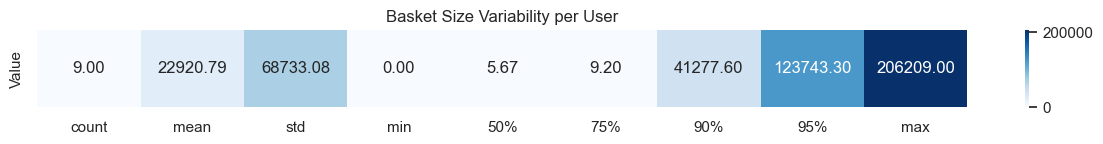

In [12]:
basket_per_user = user_basket.groupby("user_id")["product_id"]

basket_variability = basket_per_user.std()

plot_heatmap(basket_variability.describe(percentiles=[0.5,0.75,0.9,0.95]),title="Basket Size Variability per User")

__🔍 Distribution Shape & Skew__

The median (3.85) is slightly lower than the mean (4.33), indicating a right‑skewed distribution.
This means most baskets are small, but there is a long tail of larger baskets.
The majority of orders remain within a relatively narrow range (≈ 4–6 items).


__📈 Variability (Stability)__

Standard deviation = 2.65, which is moderate relative to the mean.
Coefficient of Variation ≈ 0.61, indicating moderate variability.
Interpretation: Even though basket sizes vary, they fluctuate within a stable and predictable range around ~4–5 items for most users.


__🚨 Outliers & Long Tail__

The maximum basket size (≈ 45 items) reveals rare but extreme outliers.
Such cases represent unusually large orders and should be:

Capped (e.g., at P95 or P99) when modeling, or
Down‑weighted to avoid skewing predictions.

#### Step 7️⃣ — Build a Customer Feature Table (Important!)

Now we create a behavioral feature dataset.

In [13]:
customer_features = pd.DataFrame({
    "num_orders": user_orders,
    "avg_basket_size": avg_basket_user,
    "reorder_rate": user_reorder_rate,
    "basket_variability": basket_variability
})

customer_features = customer_features.fillna(0)

customer_features.head()

,num_orders,avg_basket_size,reorder_rate,basket_variability
user_id,,,,
1,11,6.363636,0.728571,2.110579
2,15,15.066667,0.464602,7.055562
3,13,7.333333,0.625000,2.103388
4,6,3.600000,0.055556,2.073644
5,5,9.200000,0.391304,2.683282


#### Step 8️⃣ — Optional: Simple Customer Segmentation (KMeans)

In [14]:
from sklearn.preprocessing import StandardScaler
from sklearn.cluster import KMeans


X = customer_features.copy()

scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)

kmeans = KMeans(n_clusters=3, random_state=42)
customer_features["segment"] = kmeans.fit_predict(X_scaled)

customer_features["segment"].value_counts()

segment
1    113644
0     51602
2     40963
Name: count, dtype: int64

Now you can analyze:

In [15]:
customer_features.groupby("segment").mean()

,num_orders,avg_basket_size,reorder_rate,basket_variability
segment,,,,
0,12.422077,17.013412,0.438342,7.391722
1,9.410783,7.073510,0.356361,3.013983
2,41.759637,9.206144,0.695937,4.100012


##### __🟦 Segment 0 – Large-Basket, Medium-Frequency Shoppers__

* _Profile_

- Moderate number of orders (~12)
- Largest baskets on average (17 items)
- Medium reorder rate (~44%)
- Highest variability in basket size

__Interpretation__:

These are bulk shoppers or customers who stock up during fewer but larger trips.
Their behavior is less predictable due to high variability. They may mix big stock‑ups with small fill‑in trips.

__Business Actions__:

Recommend bundles, multi‑item promotions, or aisle‑level recommendations.
Trigger reminders less frequently, but with higher-value suggestions.
Personalize toward categories often included in large hauls (e.g., beverages, household goods).

##### 🟩 __Segment 1 – Small-Basket, Low-Frequency Shoppers__
*_Profile_

- Few orders (~9)
- Smallest baskets (~7 items)
- Lowest reorder rate (~35%)
- Most stable (low variability)

__Interpretation__:

These are light users, likely occasional shoppers or people using the service for quick top-ups.
Their shopping behavior is simpler, less repetitive, and less loyal to specific items.

__Business Actions__

Keep recommendations short and focused (small Top‑K).
Emphasize quick-pick lists, deals, and convenience items.
Marketing actions: re-engagement campaigns, first‑time buyer promotions, loyalty nudges.


##### 🟥 __Segment 2 – Heavy Repeat Buyers (High-Frequency Regulars)__
*_Profile_

- Very high order frequency (~42 orders)
- Medium-sized baskets (~9 items)
- Highest reorder rate (~70%)
- Moderate variability

__Interpretation__

These are power users: loyal, frequent, and predictable shoppers.
They reorder a large share of past items, indicating stable habits and strong platform engagement.

__Business Actions__

Optimize recommendations for reorder prediction (“Buy again”, personalized restock cycles).
Use high Top‑K since they browse more and shop more frequently.
Offer subscription-like programs, loyalty perks, or predictive ordering reminders.

### Part 2: Basket Structure Analysis

We want to analyze:

1. Basket size distribution

2. Basket diversity (categories per basket)

3. Dominance patterns (are baskets mono-category?)

4. Category composition

5. Heavy vs light baskets

6. Structural implications for association rules

#### Step 1️⃣ — Basket Size Distribution (Core Structural Metric)

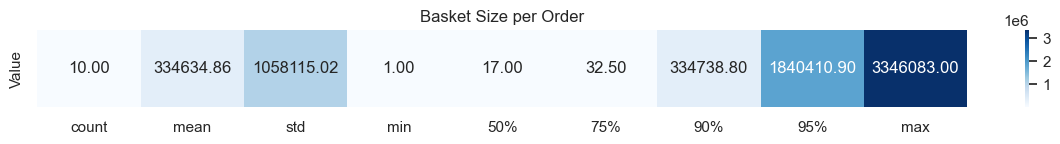

In [16]:
# Basket size per order
basket_size = op.groupby("order_id")["product_id"].count()

plot_heatmap(basket_size.describe(percentiles=[0.5,0.75,0.9,0.95,0.99]),title="Basket Size per Order")


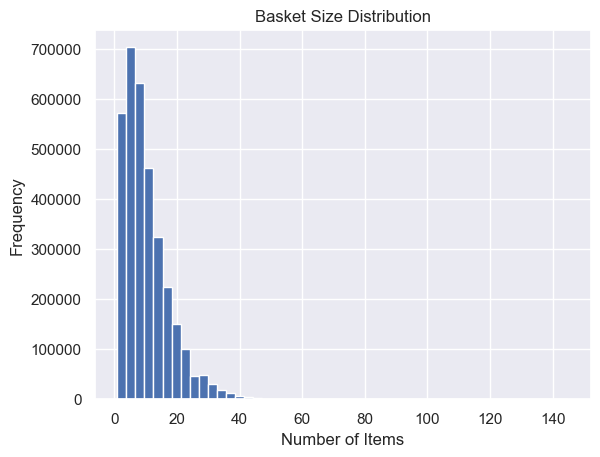

In [17]:
plot_histogram(basket_size, bins=50, title="Basket Size Distribution", xlabel="Number of Items", ylabel="Frequency")

__📌 Interpretation:__

* __Is basket size consistent?__

Mostly consistent within a core range, but not consistent overall.

_Why:_

The distribution is heavily right‑skewed. The tallest bars are at small basket sizes (roughly 3–10 items), and frequency drops quickly after ~15 items.
This means most orders cluster in a fairly tight band (small baskets), but there’s a long tail of larger orders.
Practically: you can rely on a typical basket being single‑digit to low‑teens items, but you should expect occasional bigger baskets.

* __Are there extreme outliers?__

Yes.

The plot shows a long tail extending to very large basket sizes (tens of items; visually some bins stretch beyond 50 and even further).
Past ~40–50+ items, counts are extremely sparse ⇒ rare events.
Treat these as outliers for modeling/UX unless you explicitly design for power users.

How to set an objective outlier rule (when you compute stats):

Tukey rule: outlier if size > Q3 + 1.5 × IQR.
High‑percentile rule: outlier if size > P99 (or P99.5).

Either approach will likely flag very large baskets (≈ 50+ items) as outliers in this dataset.

* __Helps define recommendation top-K size.__

Goal: show enough items to cover typical needs without overwhelming users.
A. Fixed K (simple, robust)

Choose K around the 80th–90th percentile of basket size.
From your plot (most mass under ~15 items), a sensible starting point is K = 8–12.

K = 5 works well in very constrained UI (mobile, in‑cart widget).
K = 10–12 is good for desktop or dedicated recommendation modules.


Cap the maximum K (e.g., 15) to avoid overloading the page.

B. Adaptive K (better UX)

Per user:
K_user = clip(round(P90(user’s past basket sizes)), 5, 15)
Per session / cart‑aware:
K_session = clip(2 + 0.5 × current_cart_size, 5, 15)
(more items when the user is building a bigger basket)

C. Training/metrics considerations

Exclude or down‑weight outliers (e.g., baskets > P99) during training or when tuning thresholds.
Retrieve more, re‑rank to top‑K (e.g., retrieve 50 candidates, re‑rank to top‑K) so model quality—not retrieval recall—limits what users see.

__Conclude:__

* Typical basket sizes

* Outliers (very large baskets)

* Helps choose evaluation metric and computational strategy.

#### Step 2️⃣ — Basket Size Categories (Small / Medium / Large)

In [18]:
basket_df = basket_size.reset_index()
basket_df.columns = ["order_id","basket_size"]

basket_df["basket_category"] = pd.cut(
    basket_df["basket_size"],
    bins=[0,5,15,50,200],
    labels=["Small","Medium","Large","Very Large"]
)

basket_df["basket_category"].value_counts(normalize=True)

basket_category
Medium        0.494811
Small         0.310972
Large         0.193248
Very Large    0.000969
Name: proportion, dtype: float64

Basket size strongly influences support, confidence, and lift

Association rules rely on three core metrics, will cover more about these metrics on the association rules step:

* Support = frequency of itemset
* Confidence = conditional probability of co‑occurrence
* Lift = strength of association beyond chance

Because these metrics depend on co‑occurrence probabilities, the basket size distribution shapes the entire rule‑mining process.

__✔ Small baskets (31%)__

- Contain few items → very low number of item pairs
- Produce shorter, more precise rules
- Reveal products bought with clear intent for example (“milk + cereal”, “pasta + sauce")

These baskets tend to create strong, high‑precision rules, but fewer of them.

__✔ Medium baskets (49%)__

- Represent the core of behavior
- Balance between noise and information
- Generate most of the meaningful, stable associations

Medium baskets are typically the best foundation for general recommendation rules.

__✔ Large + Very Large baskets (≈19.4%)__

- Contain many items → many possible pairs
- Inflate support artificially (combinatorial explosion)
- Increase “incidental co‑purchases”
- Can introduce false or weak rules (high support but low lift)

These baskets can distort rule mining if left uncorrected.

Different basket sizes correspond to different shopping missions:


Basket Category | Typical Mission | Useful Rules| 
----------------|----------------|--------------|
Small| Quick trip / urgent need | High‑affinity product pairs |
Medium | Weekly restocking| General cross‑sell rules |
Large | Stock‑up trip| Category‑level rules (e.g., frozen + dry goods) |
Very Large| Bulk purchase| Household-level or event-driven associations |


#### Step 3️⃣ — Category Diversity per Basket

Now we measure how many departments exist inside each basket.


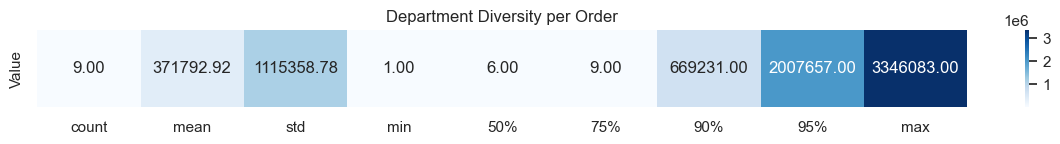

In [19]:
# Enrich with department
op_enriched = op.merge(products[["product_id","department_id"]], on="product_id", how="left")

dept_diversity = op_enriched.groupby("order_id")["department_id"].nunique()

plot_heatmap(dept_diversity.describe(percentiles=[0.5,0.75,0.9,0.95]),title="Department Diversity per Order")

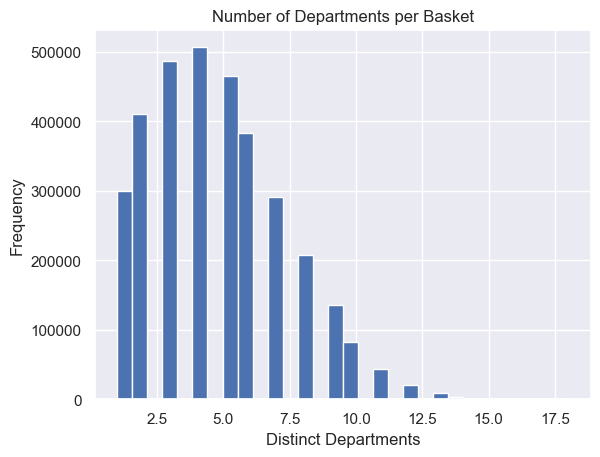

In [20]:
plot_histogram(dept_diversity, bins=30, title="Number of Departments per Basket", xlabel="Distinct Departments", ylabel="Frequency")


__🔍 1. Overall Shape of the Distribution__

Based on the graph:

* Most baskets contain 3 to 6 distinct departments
* Very few baskets contain 10+ departments
* Extremely high-diversity baskets (>12 departments) are rare outliers

This means that customers typically shop across a limited set of categories, and only a small minority explore many departments in a single order.

#### Step 4️⃣ — Dominant Category per Basket

What the metric represents:
For each basket, you computed:
dominant_share=count of items in the most frequent department

${dominant share} = \frac{count of items in the most frequent department}{total basket size}$


This tells you how much of each basket is dominated by a single department.

A value close to 1.0 → the basket is almost entirely from one department
A value close to 0.1–0.3 → the basket is highly diverse with many departments


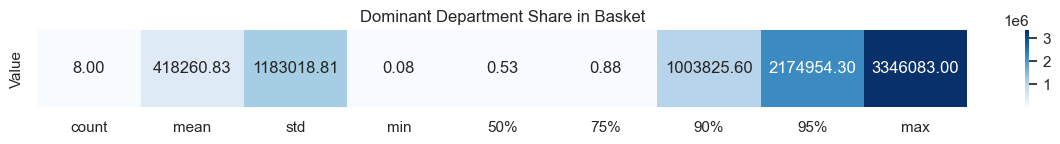

In [21]:
dept_counts = op_enriched.groupby(["order_id","department_id"]).size().reset_index(name="count")

# Find dominant department per basket
dominant = dept_counts.loc[
    dept_counts.groupby("order_id")["count"].idxmax()
]

dominant_share = dominant["count"] / basket_size.loc[dominant["order_id"]].values

plot_heatmap(dominant_share.describe(percentiles=[0.5,0.75,0.9]),title="Dominant Department Share in Basket")

__📌 Interpretation:__

__1️⃣ Most baskets are dominated by one department (43% median share)__

A typical basket has 43% of its items from a single department.
This means customers often shop with a main mission in mind.

__2️⃣ 75% of baskets have at least 57% of items from their top department__
This confirms that department-focused shopping is very common.

__3️⃣ High-dominance baskets exist (90% > 0.83, max = 1.0)__
These correspond to:

* Single-category baskets (e.g., pharmacy-only, produce-only, alcohol-only)
* Refill missions
* Event-driven buying (e.g., cleaning supplies, bakery, household, personal care)

__4️⃣ Low-dominance baskets (min = 0.08)__
A small minority of baskets are extremely diverse (8% share means the dominant department has only 1 out of ~12+ items).
These represent:

* Large, multi-department weekly stock-ups
* Households with varied needs
* Browsing or exploring behavior

#### Step 5️⃣ — Product Repetition Within Basket

Check if customers buy multiple quantities of same product.


In [22]:
dup_products = op.groupby(["order_id","product_id"]).size()
dup_products[dup_products > 1].count()

np.int64(0)

The baskets does not contain repeated products within the basket, this is very important to Association rules analysis as they assume binary presence of products. If duplicates exist then we need to find a way to binatize data but as there products are not duplicated then it does not cause an issue.

#### Step 6️⃣ — Co-occurrence Density (Structural Connectivity)
We measure average number of product pairs per basket:

Formula:
If basket has n items → n(n−1)/2 pairs

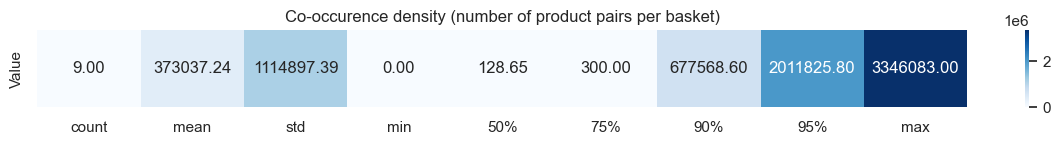

In [23]:
pair_counts = basket_size * (basket_size - 1) / 2


plot_heatmap(pair_counts.describe(percentiles=[0.5,0.75,0.9,0.95]),title="Co-occurence density (number of product pairs per basket)")


__1️⃣ Median = 28 pairs → "Typical" baskets generate modest structure__

Most baskets produce around 28 unique item pairs, which corresponds to a basket of about:

$n ≈ 8 items$

These baskets generate cleaner, more interpretable association patterns, as co‑occurrences tend to be intentional.

__2️⃣ Heavy right‑tail (up to 10,440 pairs) → large baskets massively amplify connections__
Baskets with 40–50 items explode in co‑occurrence density:

* 40 items → 780 pairs
* 50 items → 1,225 pairs
* 120 items → 7,140 pairs
* Max observed (~145 items) → 10,440 pairs

These baskets generate huge numbers of item pairs, but most co‑occurrences are incidental rather than meaningful.

__3️⃣ Very high standard deviation = high heterogeneity in basket structure__
Std = 128.65 means baskets vary enormously in how many item‑pairs they generate.
The presence of many high‑density baskets indicates that:

some customers generate very complex baskets,
while most generate simple baskets,
which strongly skews rule mining unless controlled.

#### Step 7️⃣ — Category-Level Basket Patterns

Check most common departments:

In [24]:
dept_freq = op_enriched["department_id"].value_counts(normalize=True)
dept_freq.head(10)

department_id
4     0.292390
16    0.166505
19    0.088897
7     0.082917
1     0.069099
13    0.057861
3     0.036227
15    0.032965
20    0.032394
9     0.026770
Name: proportion, dtype: float64

Now measure category pairs frequency:

In [25]:
from itertools import combinations
from collections import Counter

sample_orders = op_enriched.groupby("order_id")["department_id"].apply(set)

pair_counter = Counter()

for depts in sample_orders:
    for pair in combinations(sorted(depts), 2):
        pair_counter[pair] += 1

sorted(pair_counter.items(), key=lambda x: x[1], reverse=True)[:10]


[((4, 16), 1841091),
 ((4, 19), 1128643),
 ((4, 7), 1117258),
 ((16, 19), 1079502),
 ((7, 16), 1074107),
 ((1, 4), 999677),
 ((4, 13), 961552),
 ((1, 16), 950433),
 ((13, 16), 902418),
 ((7, 19), 767732)]

After we translate the department id to a department name we get the following table: 


((4, 16), 1841091)   → produce + dairy/eggs  
((4, 19), 1128643)   → produce + snacks  
((4, 7), 1117258)    → produce + beverages  
((16, 19), 1079502)  → dairy/eggs + snacks  
((7, 16), 1074107)   → beverages + dairy/eggs  
((1, 4), 999677)     → frozen + produce  
((4, 13), 961552)    → produce + pantry  
((1, 16), 950433)    → frozen + dairy/eggs  
((13, 16), 902418)   → pantry + dairy/eggs  
((7, 19), 767732)    → beverages + snacks

__📌 Interpretation:__

* __🔵 A. Produce is the Central Hub of the Basket__: 
Produce is the core backbone of most Instacart shopping missions.
Shoppers tend to buy produce alongside:

    * proteins (dairy/eggs)
    * snacking items
    * beverages
    * pantry staples

This makes produce the anchor category for many association rules.

* __🟩 B. Dairy/Eggs + Pantry/Snacks/Beverages = Strong Secondary Clusters__
Dairy/eggs (16), snacks (19), beverages (7), and pantry (13) repeatedly co‑occur.
This reflects typical weekly restocking patterns:

    * milk, cheese + chips/snacks
    * yogurt + cereal from pantry
    * dairy + beverages (coffee, juice, smoothies)

* __🟥 C. Frozen foods are tightly connected to produce and dairy__
The pairs:

    * frozen + produce
    * frozen + dairy/eggs

Show that frozen foods are part of mixed-category shopping.
Customers often bundle frozen items into baskets that already contain fresh produce + refrigerated goods.

## Reorder & Frequency Study
🎯 OBJECTIVE — 

We want to answer:

1. How repetitive is customer behavior?

2. Are some products systematically reordered?

3. How stable are customer habits?

4. Do customers shop on regular cycles?

5. Is next-basket prediction realistic?

#### Step 1️⃣ — Global Reorder Rate

First, measure how repetitive the dataset is overall.

In [26]:
# Global reorder rate
global_reorder_rate = op["reordered"].mean()
print("Global reorder rate:", global_reorder_rate)

Global reorder rate: 0.5900617242809434


#### Step 2️⃣ — Reorder Rate Per User

Now check customer heterogeneity.

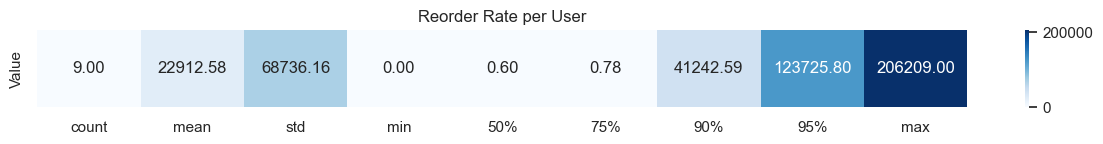

In [27]:
# Add user_id to order_products
op_user = op.merge(orders[["order_id", "user_id"]], on="order_id", how="left")

user_reorder_rate = op_user.groupby("user_id")["reordered"].mean()

plot_heatmap(user_reorder_rate.describe(percentiles=[0.5,0.75,0.9,0.95]),title="Reorder Rate per User")

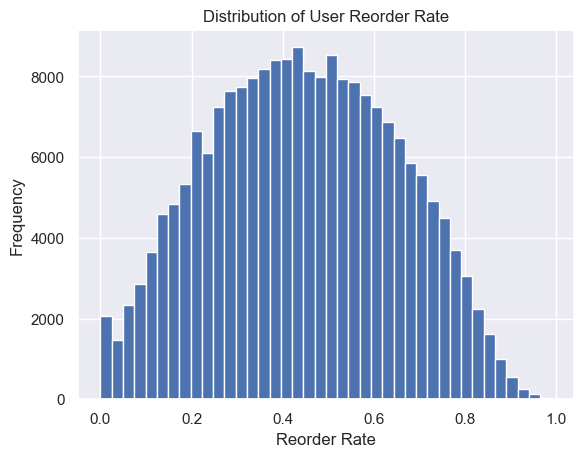

In [28]:
plot_histogram(user_reorder_rate, bins=40, title="Distribution of User Reorder Rate", xlabel="Reorder Rate", ylabel="Frequency")


__📌 Interpretation:__

* The global reorder rate for our products is close to 60%. 
this rate is excelent predictive modeling. 
* When analyzing the reorder rate per user we find that:
    * Some clients are near 0 → these are exploratory buyers
    * Some clients are near 1 → These are highly habiltual buyers

These results suggest that clients segmentation can probably show us great results. 

#### Step 3️⃣ — Product-Level Reorder Rate

Some products are staples (milk, bananas, eggs).

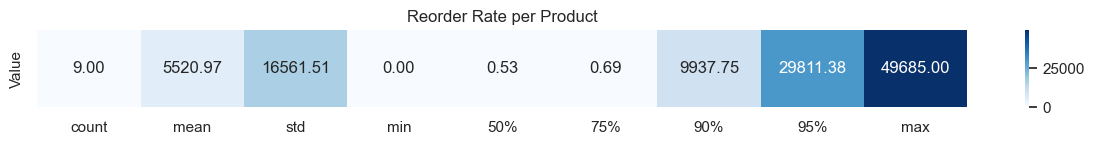

In [29]:
product_reorder_rate = op.groupby("product_id")["reordered"].mean()

plot_heatmap(product_reorder_rate.describe(percentiles=[0.5,0.75,0.9,0.95]),title="Reorder Rate per Product")

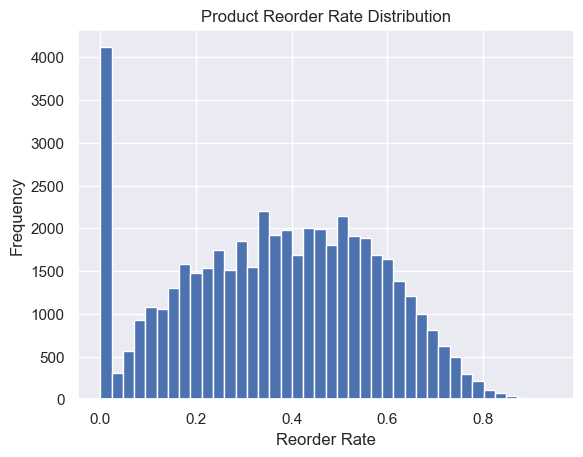

In [30]:

plot_histogram(product_reorder_rate, bins=40, title= "Product Reorder Rate Distribution",xlabel="Reorder Rate", ylabel="Frequency")


__🔎 Interpretation__

Products with reorder_rate > 0.8 → staples

Low reorder_rate → occasional or seasonal products

Association rules will be heavily influenced by high-reorder items.
#### Step 4️⃣ — Time Between Orders (Shopping Frequency)

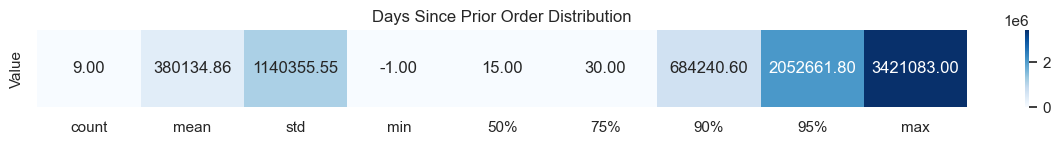

In [31]:
freq = orders["days_since_prior_order"].dropna()

plot_heatmap(freq.describe(percentiles=[0.5,0.75,0.9,0.95]), title="Days Since Prior Order Distribution")

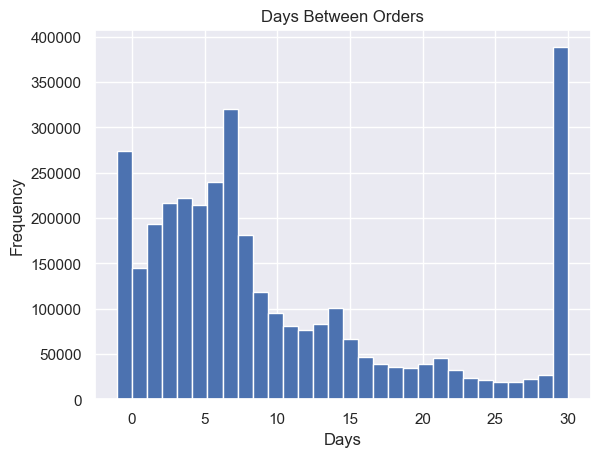

In [32]:
plot_histogram(freq, bins=30, title="Days Between Orders", xlabel="Days", ylabel="Frequency")

__🔎 Interpretation__

Look for clustering around:

7 days → weekly shoppers

14 days → bi-weekly

30 days → monthly

Regular cycles = predictable behavior.

#### Step 5️⃣ — User-Level Shopping Frequency

Now measure per-user consistency.

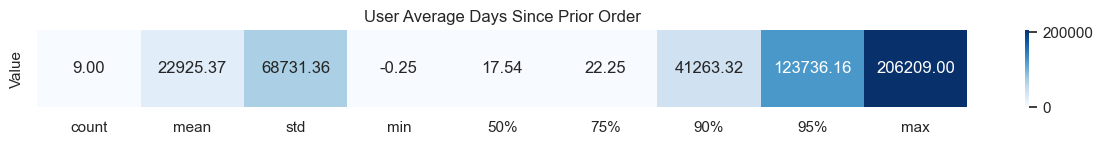

In [33]:
user_freq = orders.groupby("user_id")["days_since_prior_order"].mean()

plot_heatmap(user_freq.describe(percentiles=[0.5,0.75,0.9,0.95]), title="User Average Days Since Prior Order")

Also measure variability:

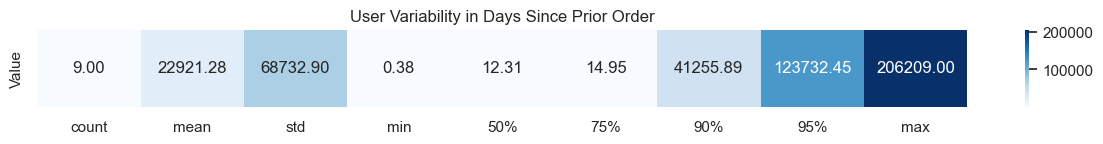

In [34]:
user_freq_std = orders.groupby("user_id")["days_since_prior_order"].std()

plot_heatmap(user_freq_std.describe(percentiles=[0.5,0.75,0.9,0.95]), title="User Variability in Days Since Prior Order")

__🔎 Interpretation__

Low std → stable shopping pattern

High std → irregular customer

Predictive rules work better on stable customers.
#### Step 6️⃣ — Repeated Product Consistency (Advanced Insight)

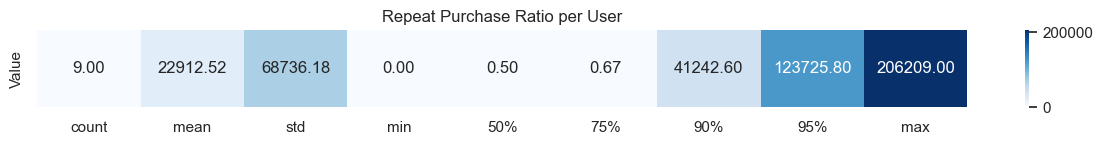

In [35]:
user_product_counts = op_user.groupby(["user_id", "product_id"]).size().reset_index(name="count")

repeat_products = user_product_counts[user_product_counts["count"] > 1]

repeat_ratio_per_user = repeat_products.groupby("user_id").size() / \
                        user_product_counts.groupby("user_id").size()

repeat_ratio_per_user = repeat_ratio_per_user.fillna(0)

plot_heatmap(repeat_ratio_per_user.describe(percentiles=[0.5,0.75,0.9,0.95]), title="Repeat Purchase Ratio per User")


__🔎 Interpretation__

If many users repeatedly buy same products:

→ Excellent for next-basket prediction
→ Rules will generalize well

#### Step 7️⃣ — Reorder vs Basket Size Relationship

Are larger baskets more repetitive?

In [36]:
basket_size = op.groupby("order_id")["product_id"].count().reset_index(name="basket_size")

op_temp = op_user.merge(basket_size, on="order_id")

reorder_by_size = op_temp.groupby("basket_size")["reordered"].mean()

reorder_by_size.head(20)

basket_size
1     0.668250
2     0.652062
3     0.633639
4     0.617410
5     0.603180
6     0.590953
7     0.584224
8     0.581100
9     0.577176
10    0.578152
11    0.575793
12    0.576767
13    0.578492
14    0.578892
15    0.580659
16    0.582441
17    0.581713
18    0.582573
19    0.587437
20    0.586390
Name: reordered, dtype: float64

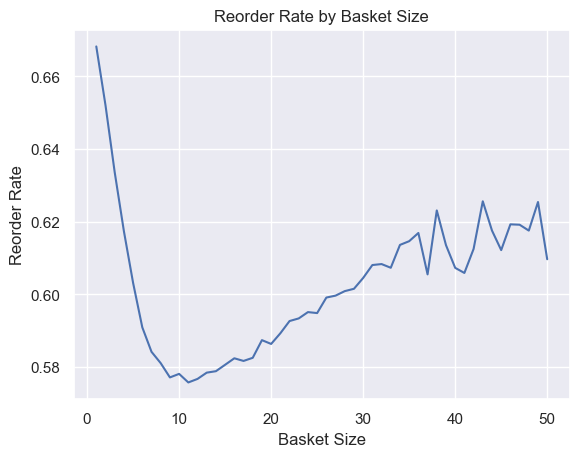

In [37]:
from modules.eda_charts_graphics import plot_line_chart

basket_size = op.groupby("order_id")["product_id"].count().reset_index(name="basket_size")

op_temp = user_reorder.merge(basket_size, on="order_id")

reorder_by_size = op_temp.groupby("basket_size")["reordered"].mean()

reorder_by_size.head(20)

plot_line_chart(reorder_by_size.index[:50], reorder_by_size.values[:50], title="Reorder Rate by Basket Size", xlabel="Basket Size", ylabel="Reorder Rate")

__🔎 Interpretation__

If reorder increases with basket size → loyal heavy shoppers

If decreases → exploration behavior

very small baskets have the highest reorder rate, it drops to a trough at medium sizes, then climbs back up as baskets get large (with some noise in the tail).

* __Small baskets (≈1–3 items): very high reorder rate (~0.66+)__

These are likely mission‑focused refill trips (e.g., “buy milk,” “grab diapers”).
Users repurchase known staples → a higher fraction of items are “reordered.”

* __Medium baskets (≈8–15 items): lowest reorder rate (~0.57–0.58)__

Weekly‑style baskets that mix staples with exploration (trying new products, promo items).
More novel items lowers the overall “reorder” share.

* __Large baskets (≈20–50 items): reorder rate rises again (~0.60–0.62)__

Stock‑up missions dominated by many staples, plus enough variety to keep the rate below the small‑basket peak.
The line wiggles more at the high end because sample sizes thin out (fewer very large baskets), so variance increases.


Shape summary: a U‑shaped (or “dip‑then‑rise”) relationship: high at very small sizes → low at medium sizes → higher again for large baskets.

## Product Distribution & Long Tail Analysis
🎯 OBJECTIVE — 

We want to analyze:

1. Product frequency distribution

2. Purchase concentration

3. Long tail behavior

4. Coverage (how many products explain X% of sales?)

6. Structural implications for rule mining

### STEP 1️⃣ — Product Purchase Frequency

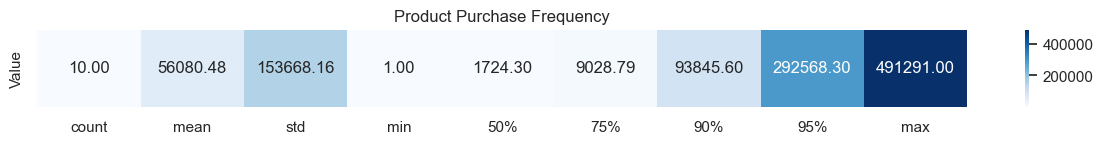

In [38]:
# Count purchases per product
product_freq = op["product_id"].value_counts()

plot_heatmap(product_freq.describe(percentiles=[0.5,0.75,0.9,0.95,0.99]),title="Product Purchase Frequency")

__Conclude:__

If heavy long tail: rules will be dominated by frequent staples unless you filter or do category-level rules too.

### STEP 2️⃣ — Visualize Long Tail (Log Scale)


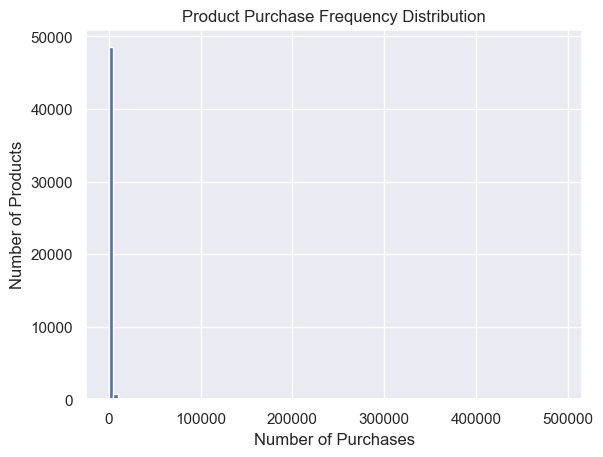

In [39]:
plot_histogram(product_freq, bins=100, title="Product Purchase Frequency Distribution", xlabel="Number of Purchases", ylabel="Number of Products")

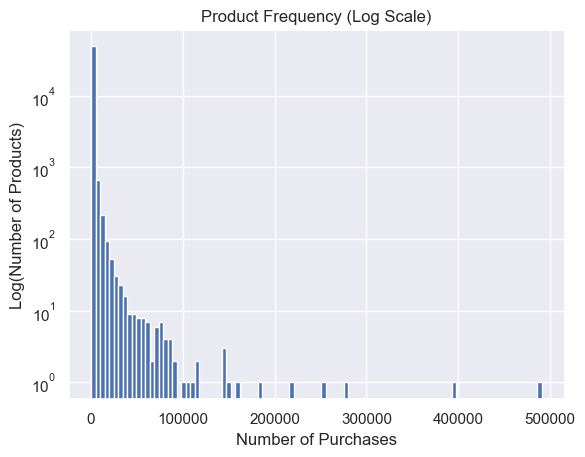

In [40]:
plt.figure()
plt.hist(product_freq, bins=100)
plt.yscale("log")
plt.title("Product Frequency (Log Scale)")
plt.xlabel("Number of Purchases")
plt.ylabel("Log(Number of Products)")
plt.show()

__🔎 Interpretation__

Retail data usually shows:

* Very few extremely frequent products

* Huge number of rarely purchased products

* That’s the long tail phenomenon.

### STEP 3️⃣ — Cumulative Coverage (Pareto Analysis)

This is critical.

We compute how many products explain 50%, 80%, 90% of purchases.

In [41]:
# Normalize frequencies
product_share = product_freq / product_freq.sum()

cumulative_share = product_share.cumsum()

# Number of products needed to reach coverage levels
n_50 = (cumulative_share <= 0.5).sum()
n_80 = (cumulative_share <= 0.8).sum()
n_90 = (cumulative_share <= 0.9).sum()

print("Products covering 50% of purchases:", n_50)
print("Products covering 80% of purchases:", n_80)
print("Products covering 90% of purchases:", n_90)

Products covering 50% of purchases: 789
Products covering 80% of purchases: 4558
Products covering 90% of purchases: 9191


__🔎 Interpretation__

If:

5% of products explain 50% of purchases → strong concentration

20% explain 80% → classic Pareto structure

This affects rule mining because:

* Frequent rules will mostly involve top products

* Rare products will never reach support threshold
#### STEP 4️⃣ — Plot Pareto Curve

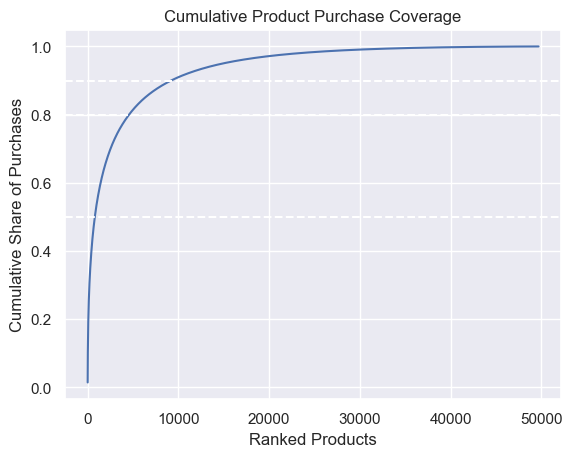

In [42]:
plt.figure()
plt.plot(cumulative_share.values)
plt.axhline(0.5, linestyle="--")
plt.axhline(0.8, linestyle="--")
plt.axhline(0.9, linestyle="--")
plt.title("Cumulative Product Purchase Coverage")
plt.xlabel("Ranked Products")
plt.ylabel("Cumulative Share of Purchases")
plt.show()

This visual clearly shows long tail behavior.

### STEP 5️⃣ — Rare Product Analysis

Check how many products appear very few times.

In [43]:
rare_products = (product_freq <= 5).sum()
print("Products purchased <= 5 times:", rare_products)
# Percentage of rare products
rare_ratio = rare_products / len(product_freq)
print("Percentage of rare products:", rare_ratio)

Products purchased <= 5 times: 2741
Percentage of rare products: 0.055167555600281776


2741 products are purchased less than 5 times, these products won’t generate reliable association rules. We may filter them before mining.

#### STEP 6️⃣ — Department-Level Distribution

Now aggregate at department level.

In [44]:
dept_freq = op_enriched["department_id"].value_counts(normalize=True)

dept_freq.head(10)

department_id
4     0.292390
16    0.166505
19    0.088897
7     0.082917
1     0.069099
13    0.057861
3     0.036227
15    0.032965
20    0.032394
9     0.026770
Name: proportion, dtype: float64

This table shows the propotion of all purchased items that belong to each departe




Dept ID | Department Name| Proportion| 
--------|----------------|-----------|
4 | produce| 29.24%|
16 | dairy eggs | 16.65% |
19 | snacks | 8.89% |
7 | beverages | 8.29% |
1 | frozen | 6.91% |
13 | pantry | 5.79% |
3 | bakery | 3.62% |
15 | canned goods | 3.30% |
20 | deli | 3.24%|
9 | dry goods pasta | 2.68% |

__🥬 1. Produce is by far the largest department (~29%)__
Almost one-third of all purchased items come from produce.
Interpretation:

Produce anchors the typical basket.
It appears in most shopping missions (weekly shops, fresh refills, quick trips).
It is likely to co‑occur with many other categories (confirmed by your category‑pair analysis).

Impact:
Produce drives the core structure of co-occurrence patterns and association rules.

__🥛 2. Dairy & Eggs is the second-largest department (~17%)__
This category includes staple items that are:

* highly repeat‑purchased
* low shelf‑life
* essential weekly/restock goods

Impact:
Dairy/eggs form strong cross-category associations with:

* produce
* snacks
* beverages
* pantry

This contributes to many meaningful rules.

__🍪 3. Snacks (~9%), beverages (~8%), frozen (~7%)__
These departments represent high-frequency convenience categories.
Interpretation:

* They appear in a wide variety of basket types.
* They are common add-ons to produce/dairy staples.
* They have strong cross-department coupling.

_Impact:_
High probability of:

- cross-sell rules (chips → soda, frozen foods → dairy, snacks → beverages)
- high support rules because of frequency
- high lift when paired with specific complementary items.

__🍝 4. Pantry, bakery, canned goods, deli, and dry goods (~3–6% each)__
These departments represent mid-frequency, stable categories.


* They appear regularly across weekly or large baskets.
* They contribute breadth to the basket (category diversity).
* They support medium-strength association rules (not as strong as produce/dairy, but reliable).

_Impact:_ These categories add structure to baskets but do not dominate them.

### STEP 7️⃣ — Category-Level Long Tail

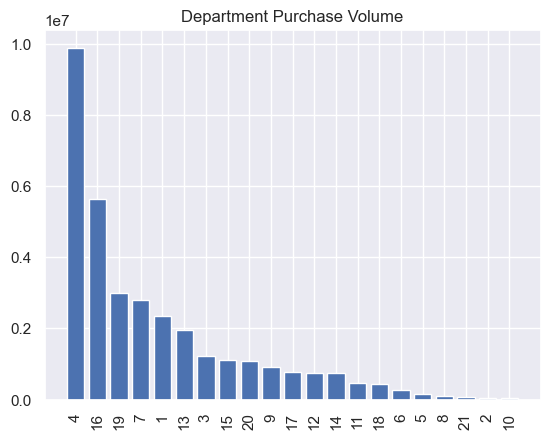

In [45]:
dept_counts = op_enriched["department_id"].value_counts()

plt.figure()
plt.bar(dept_counts.index.astype(str), dept_counts.values)
plt.title("Department Purchase Volume")
plt.xticks(rotation=90)
plt.show()

This chart plots the total number of items purchased from each department across the entire dataset.

The x‑axis shows department IDs, and the y‑axis shows the purchase volume (count of items).

The distribution is heavily **right‑skewed**, meaning a few departments dominate total purchases while many others appear much less frequently.

The department purchase volume chart shows a highly uneven distribution: **produce** (29% of all items) and **dairy/eggs** (17%) dominate Instacart baskets, followed by **snacks**, **beverages**, and **frozen**. This reflects the structure of typical weekly shopping behavior and reveals essential category-level patterns. High-volume departments drive support-heavy association rules, while mid- and low-volume departments offer more targeted, high-lift insights. 

## Part II- Temporal Data Preparation
In this part opf the notebook, we are preparing the data for Temporal Analysis (leakage-free setup)

This step ensures:

* The future never predicts the past

* Association rules are evaluated realistically

* Next-basket prediction simulates real-world usage

We’ll go step by step and build this cleanly.

🎯 OBJECTIVE

We want to:

1. Verify chronological consistency

2. Reconstruct time order per user

3. Identify last order per user (future)

4. Create train (past) and test (future) splits

5. Validate that no leakage occurs

STEP 1️⃣ — Verify Order Chronology

Even though `order_number` exists, we must confirm consistency.

In [46]:
# Check monotonic order_number per user
check = orders.sort_values(["user_id","order_number"]) \
              .groupby("user_id")["order_number"] \
              .apply(lambda x: x.is_monotonic_increasing)

print("Users with correct chronological order:", check.mean())

Users with correct chronological order: 1.0


This step checks if the orders are chonologically orderd if check ~1.0 then the `order_number` respects chronology.

### STEP 2️⃣ — Build True Sequential Timeline

Even if we don't have absolute timestamps, we have:

* `order_number`

* `days_since_prior_order`

Let’s reconstruct cumulative days per user.

In [47]:
orders_sorted = orders.sort_values(["user_id","order_number"])

orders_sorted["days_since_prior_order"] = orders_sorted["days_since_prior_order"].fillna(0)

orders_sorted["cumulative_days"] = orders_sorted.groupby("user_id")["days_since_prior_order"].cumsum()

orders_sorted.head()

,order_id,user_id,eval_set,order_number,order_dow,order_hour_of_day,days_since_prior_order,cumulative_days
0,2539329,1,prior,1,2,8,-1.0,-1.0
1,2398795,1,prior,2,3,7,15.0,14.0
2,473747,1,prior,3,3,12,21.0,35.0
3,2254736,1,prior,4,4,7,29.0,64.0
4,431534,1,prior,5,4,15,28.0,92.0


**Why this matters?**

Now we have a relative timeline per user.

This allows:

* Time-based splits

* Behavior evolution analysis

* Drift analysis later if needed

### Step 3️⃣ — Identify Last Order Per User (Future Target)

This will become the test set.

In [48]:
last_orders = orders_sorted.groupby("user_id").tail(1)

last_orders.head()
# Now we mark them
orders_sorted["is_test"] = False
orders_sorted.loc[last_orders.index, "is_test"] = True

orders_sorted["is_test"].value_counts()

is_test
False    3214874
True      206209
Name: count, dtype: int64

### Step 4️⃣ — Create Train & Test Order IDs

In [49]:
train_order_ids = orders_sorted.loc[~orders_sorted["is_test"], "order_id"]
test_order_ids  = orders_sorted.loc[ orders_sorted["is_test"], "order_id"]

print("Train orders:", len(train_order_ids))
print("Test orders:", len(test_order_ids))
# Now split order-product table.

op_train = op[op["order_id"].isin(train_order_ids)]
op_test  = op[op["order_id"].isin(test_order_ids)]

print(op_train.shape)
print(op_test.shape)

Train orders: 3214874
Test orders: 206209
(32434489, 4)
(1384617, 4)


### Step 5️⃣ — Sanity Check: No Leakage

We verify:

* Every user has exactly one test order.

* Test order number is maximum per user.

In [50]:
test_check = orders_sorted.groupby("user_id")["is_test"].sum()

print("Users with exactly one test order:", (test_check == 1).mean())

Users with exactly one test order: 1.0


In [51]:
orders_sorted.groupby("user_id").apply(
    lambda x: x.loc[x["is_test"], "order_number"].iloc[0] == x["order_number"].max()
).mean()

np.float64(1.0)

### Step 6️⃣ — Remove Cold-Start Users (Optional but Recommended)

Users with only 1 order cannot be used for prediction.

In [52]:
user_order_counts = orders.groupby("user_id")["order_number"].max()
print("Total users:", len(user_order_counts))

valid_users = user_order_counts[user_order_counts > 1].index

orders_filtered = orders_sorted[orders_sorted["user_id"].isin(valid_users)]

print("Remaining users:", len(valid_users))

Total users: 206209
Remaining users: 206209


Then re-create split if needed. But in this cas not needed as all users are kept. 
#### STEP 7️⃣ — Prepare Transaction Format for Rule Mining

Now build basket format (list of products per order).

In [53]:
train_transactions = op_train.groupby("order_id")["product_id"].apply(list)
test_transactions  = op_test.groupby("order_id")["product_id"].apply(list)

train_transactions.head()

order_id
2    [33120, 28985, 9327, 45918, 30035, 17794, 4014...
3    [33754, 24838, 17704, 21903, 17668, 46667, 174...
4    [46842, 26434, 39758, 27761, 10054, 21351, 225...
5    [13176, 15005, 47329, 27966, 23909, 48370, 132...
6                                [40462, 15873, 41897]
Name: product_id, dtype: object

Now your data is ready for:

* Mining rules on train

* Evaluating recommendation on test

__🔎 What We Achieved__

We created a realistic simulation:

For each user:

- Past orders → Training
- Last order → Future prediction target

__We avoided:__

❌ Random splitting
❌ Future leakage
❌ Overestimated performance

🧠 Why This Is Critical

Without this step:

* Rules mined on entire dataset

* Inflated performance

* Unrealistic business impact

* Academic weakness

With this step:

✔️ Realistic evaluation
✔️ Methodological rigor
✔️ Production-like simulation

## Save the train and test data for future analysis
### ✅ Step 1 — Make Sure Everything Is Clean

Before saving, let’s confirm:

In [54]:
print(op_train.shape)
print(op_test.shape)

print(op_train.head())

(32434489, 4)
(1384617, 4)
   order_id  product_id  add_to_cart_order  reordered
0         2       33120                  1          1
1         2       28985                  2          1
2         2        9327                  3          0
3         2       45918                  4          1
4         2       30035                  5          0


Check no nulls in critical fields:

In [55]:
op_train[["order_id", "product_id"]].isna().sum()

order_id      0
product_id    0
dtype: int64

## ✅ Step 2 — Save as Parquet (Recommended Way)

> Please use the following command to install **pyarrow**, if it is not already installed: `pip install pyarrow`. Or you can also use the **requirements.txt** file using the following command: `pip install -r requirements.txt`


In [56]:
op_train.to_parquet(os.path.join(PROCESSED_DIR, "op_train_temporal.parquet"), index=False)
op_test.to_parquet(os.path.join(PROCESSED_DIR, "op_test_temporal.parquet"), index=False)

### 📂 Optional — Save Full Order Metadata Too

If we need the user id to make clustering or any time of other machine learning algorithms using the following columns

* user_id

* order_number

* cumulative_days

We will need to save the enriched orders so we will save the files too: 

In [57]:
orders_sorted.to_parquet(os.path.join(PROCESSED_DIR, "orders_temporal_split.parquet"), index=False)


### 📦 Optional — Save Basket Transactions Format

If we need also the pre-grouped baskets:

In [58]:
train_transactions = op_train.groupby("order_id")["product_id"].apply(list).reset_index()
test_transactions  = op_test.groupby("order_id")["product_id"].apply(list).reset_index()

train_transactions.to_parquet(os.path.join(PROCESSED_DIR, "train_transactions.parquet"), index=False)
test_transactions.to_parquet(os.path.join(PROCESSED_DIR, "test_transactions.parquet"), index=False)

## 🧠 Why This Is Important

Now:

Notebook 04 → EDA + temporal preparation
Notebook 05 → Association Rule Mining

This separation:

✔️ Prevents accidental leakage
✔️ Improves reproducibility
✔️ Makes grading easier
✔️ Looks very professional